In [1]:
import pandas as pd
from sklearn import tree


In [2]:
demographics_data = pd.read_csv("../Dataset/Demographics/demographics.csv")
sensing_data = pd.read_csv("../Dataset/Sensing/sensing.csv")
ema_data = pd.read_csv("../Dataset/EMA/general_ema.csv")

# Develop predictive modeling pipelines with customizable “features” and “outcomes”.

## Data Preprocessing Functions

In [3]:
def get_academic_quarter(day):
    """
    Convert YYYYMMDD to academic quarter (0-3)
    0: Fall (mid-Sept to late Nov)
    1: Winter (Jan to early Mar)
    2: Spring (late Mar to early June)
    3: Summer (mid-June to early Sept)
    """
    # Convert string date to datetime
    date = pd.to_datetime(str(day), format='%Y%m%d')
    month = date.month
    day = date.day
    
    if (month == 9 and day >= 15) or month == 10 or (month == 11 and day <= 30):
        return 0  # Fall
    elif month == 1 or month == 2 or (month == 3 and day <= 15):
        return 1  # Winter
    elif (month == 3 and day > 15) or month == 4 or month == 5 or (month == 6 and day <= 10):
        return 2  # Spring
    else:
        return 3  # Summer

In [4]:
# First, merge all three datasets into ONE DF
def prepare_merged_dataset(sensing_data, demographics_data, ema_data):
    """
    Merge sensing, demographics, and EMA data
    """
    # Merge sensing and demographics first
    merged = sensing_data.merge(
        demographics_data,
        on='uid',
        how='inner'
    )
    
    # Then merge with EMA data
    merged = merged.merge(
        ema_data,
        on=['uid', 'day'],
        how='inner'
    )
    
    # Add academic quarter
    merged['quarter'] = merged['day'].apply(get_academic_quarter)
    
    return merged

In [6]:
# Organized feature dictionary into categories and platforms
''' 
Categories: demographics, activity, location, phone, sleep, audio, calls, sms, light, steps, quality
Platforms: all, android, ios
'''
feature_dict = {
    'demographics': [
        'gender', 'race'
    ],
    
    'activity': {
        'all': [
            'act_in_vehicle_ep_0', 'act_on_bike_ep_0', 'act_still_ep_0'
        ],
        'android': [
            'act_on_foot_ep_0', 'act_tilting_ep_0'
        ],
        'ios': [
            'act_running_ep_0', 'act_walking_ep_0'
        ]
    },
    
    'location': [
        'loc_dist_ep_0', 'loc_visit_num_ep_0', 'loc_max_dis_from_campus_ep_0',
        'loc_food_dur', 'loc_health_dur', 'loc_home_dur', 'loc_leisure_dur',
        'loc_other_dorm_dur', 'loc_self_dorm_dur', 'loc_social_dur', 
        'loc_study_dur', 'loc_workout_dur', 'loc_worship_dur'
    ],
    
    'phone': {
        'all': [
            'unlock_duration_ep_0', 'unlock_num_ep_0'
        ],
        'ios': [
            'other_playing_duration_ep_0', 'other_playing_num_ep_0'
        ]
    },
    
    'sleep': {
        'all': [
            'sleep_duration', 'sleep_start', 'sleep_end'
        ],
        'ios': [
            'sleep_heathkit_dur'
        ]
    },
    'audio': {
        'android': [
            'audio_amp_mean_ep_0', 'audio_amp_std_ep_0',
            'audio_convo_duration_ep_0', 'audio_convo_num_ep_0',
            'audio_voice_ep_0'
        ]
    },
    
    'calls': {
        'android': [
            'call_in_duration_ep_0', 'call_in_num_ep_0',
            'call_out_duration_ep_0', 'call_out_num_ep_0',
            'call_miss_num_ep_0'
        ]
    },
    
    'sms': {
        'android': [
            'sms_in_num_ep_0', 'sms_out_num_ep_0'
        ]
    },
    
    'light': {
        'android': [
            'light_mean_ep_0', 'light_std_ep_0'
        ]
    },
    
    'steps': {
        'ios': [
            'step_ep_0'
        ]
    },
    
    'quality': {
        'all': [
            'quality_activity', 'quality_loc'
        ],
        'android': [
            'quality_audio', 'quality_light'
        ]
    }
}

## Predictive Model (Tree)

In [7]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, mean_squared_error, f1_score
from sklearn.impute import SimpleImputer
import numpy as np

class PredictiveModel:
    def __init__(self, target_col, is_classification=True, platform='all', feature_set=None, feature_dict=None, feature_list=None):
        """
        Initialize model with platform specification
        platform: 'all', 'android', or 'ios'
        """
        self.feature_dict = feature_dict
        self.target_col = target_col
        self.is_classification = is_classification
        self.platform = platform
        self.feature_list = feature_list
        self.feature_set = feature_set
        self.label_encoders = {}
        # Imputers: used for numerical and categorical variables with missing values
        self.imputer = SimpleImputer(strategy='median') # Dummy value for numerical
        self.categorical_imputer = SimpleImputer(strategy='most_frequent') # Dummy value for categorical
        
        if is_classification:
            self.model = DecisionTreeClassifier(random_state=42)
        else:
            self.model = DecisionTreeRegressor(random_state=42)
    
    def preprocess_features(self, data):
        """Preprocess features including handling missing values"""
        X = data.copy()
        categorical_cols = ['gender', 'race']
        numerical_cols = [col for col in X.columns if col not in categorical_cols]
        # Handle categorical variables with LabelEncoder (convert to numerical)
        for col in categorical_cols:
            if col in X.columns:
                X[col] = self.categorical_imputer.fit_transform(X[[col]]) # impute missing values
                # Encode
                if col not in self.label_encoders:
                    self.label_encoders[col] = LabelEncoder()
                    X[col] = self.label_encoders[col].fit_transform(X[col].astype(str))
                else:
                    X[col] = self.label_encoders[col].transform(X[col].astype(str))
        
        X[numerical_cols] = self.imputer.fit_transform(X[numerical_cols]) # Encode missing values
        return X
    
    def get_platform_features(self, data):
        """Get features based on platform selection and feature sets"""
        selected_features = []
        if self.feature_list is not None:
            return self.feature_list
        # If no feature sets specified, use all available
        if self.feature_set is None:
            self.feature_set = self.feature_dict.keys()
        
        # Adding features based on selected categories
        for category in self.feature_set:
            if category in self.feature_dict:
                if isinstance(self.feature_dict[category], dict): # Features with platform-specific categories
                    if 'all' in self.feature_dict[category]:
                        selected_features.extend(self.feature_dict[category]['all'])
                    if self.platform in self.feature_dict[category]: # IOS or Android
                        selected_features.extend(self.feature_dict[category][self.platform])
                else:
                    selected_features.extend(self.feature_dict[category])
                    # If not dictionary, then it's shared across platforms
        # Always include is_ios for platform identification
        if 'is_ios' not in selected_features:
            selected_features.append('is_ios')
        return [f for f in selected_features if f in data.columns] # Return only features that exist in the dataset
    
    def train_evaluate(self, merged_data, target_quarter, target_year):
        """Train and evaluate the model using same-quarter splitting across years"""
        # ============================ DATA PREPROCESSING ============================
        # Extract year from day column
        merged_data['year'] = merged_data['day'].astype(str).str[:4].astype(int)
        # Filter based on platform
        if self.platform == 'android':
            merged_data = merged_data[merged_data['is_ios'] == 0] # Android
        elif self.platform == 'ios':
            merged_data = merged_data[merged_data['is_ios'] == 1] # iOS
        # Filter for the specified quarter
        quarter_data = merged_data[merged_data['quarter'] == target_quarter]
        quarter_data = quarter_data.dropna(subset=[self.target_col]) # Drop NaN values in target column
        # Split by year instead of 80/20
        train_data = quarter_data[quarter_data['year'] != target_year]
        test_data = quarter_data[quarter_data['year'] == target_year]
        # Get features available in the dataset based on platform and feature set
        features = self.get_platform_features(merged_data)
        # Prepare features and target
        X_train = self.preprocess_features(train_data[features])
        X_test = self.preprocess_features(test_data[features])
    
        y_train = train_data[self.target_col]
        y_test = test_data[self.target_col]
        
        # Print data shapes and missing value info
        print(f"\nTraining data shape: {X_train.shape}")
        print(f"Testing data shape: {X_test.shape}")
        print(f"Number of features used: {len(features)}")
        
        # ============================ TRAINING MODEL ============================
        self.model.fit(X_train, y_train)
        
        # ============================ EVALUATING MODEL ============================
        y_pred = self.model.predict(X_test)
        
        # Calculate metrics
        if self.is_classification:
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')
            return {
                'accuracy': accuracy,
                'f1_score': f1,
                'n_train': len(X_train),
                'n_test': len(X_test),
                'features_used': features
            }
        else:
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            return {
                'mse': mse,
                'rmse': rmse,
                'n_train': len(X_train),
                'n_test': len(X_test),
                'features_used': features
            }

# Feature Exploration


Simplified tree for stress

Top Feature Importance:
                          feature  importance
1                             day    0.022476
432  loc_max_dis_from_campus_ep_0    0.016736
114                act_still_ep_0    0.008953
607         unlock_duration_hr_18    0.008236
602         unlock_duration_hr_13    0.007741


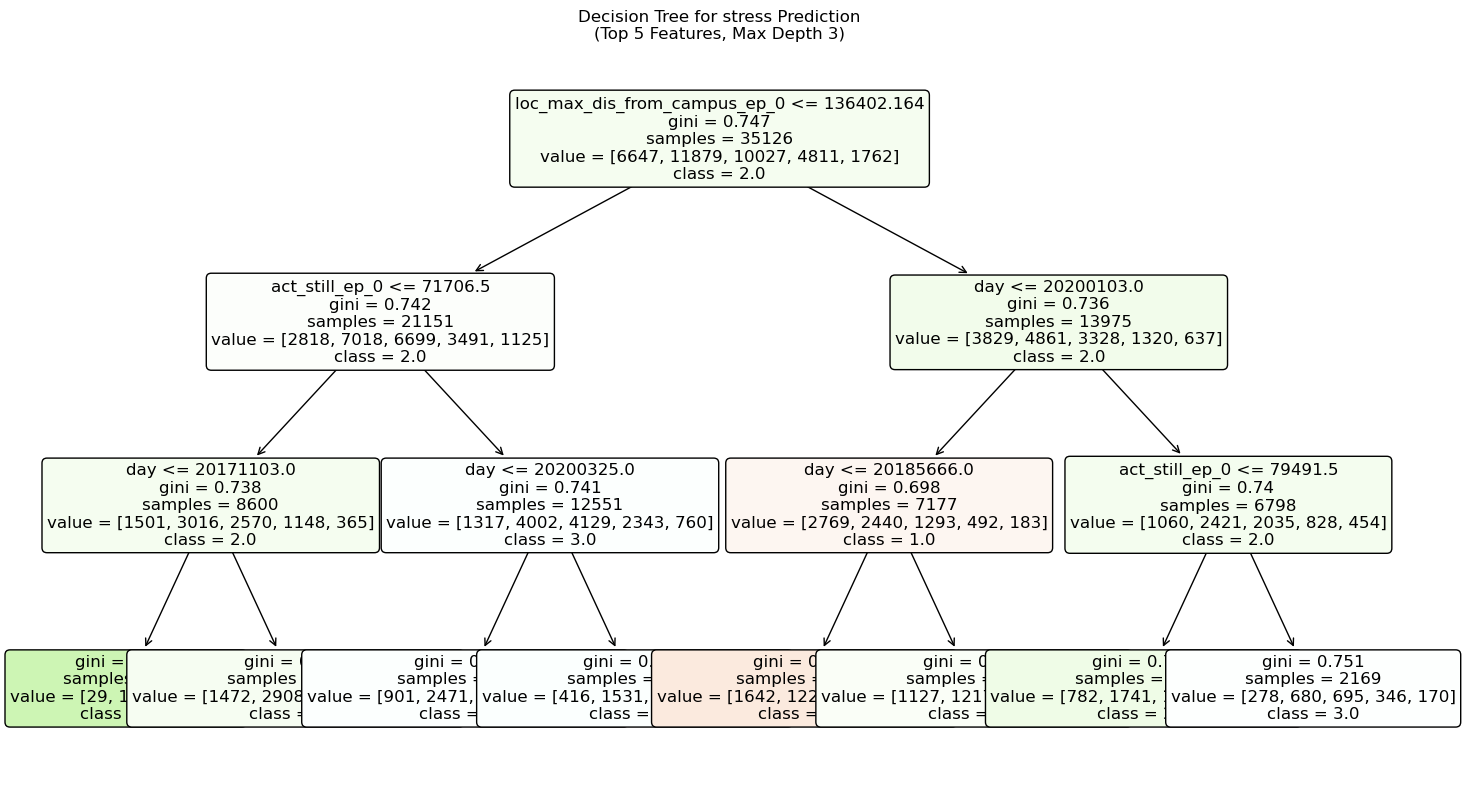


Decision Rules:

Simplified tree for social_level

Top Feature Importance:
                         feature  importance
386                loc_dist_ep_0    0.013783
524  other_playing_duration_ep_2    0.012659
1                            day    0.012059
388                loc_dist_ep_2    0.011348
427                 loc_home_dur    0.009938


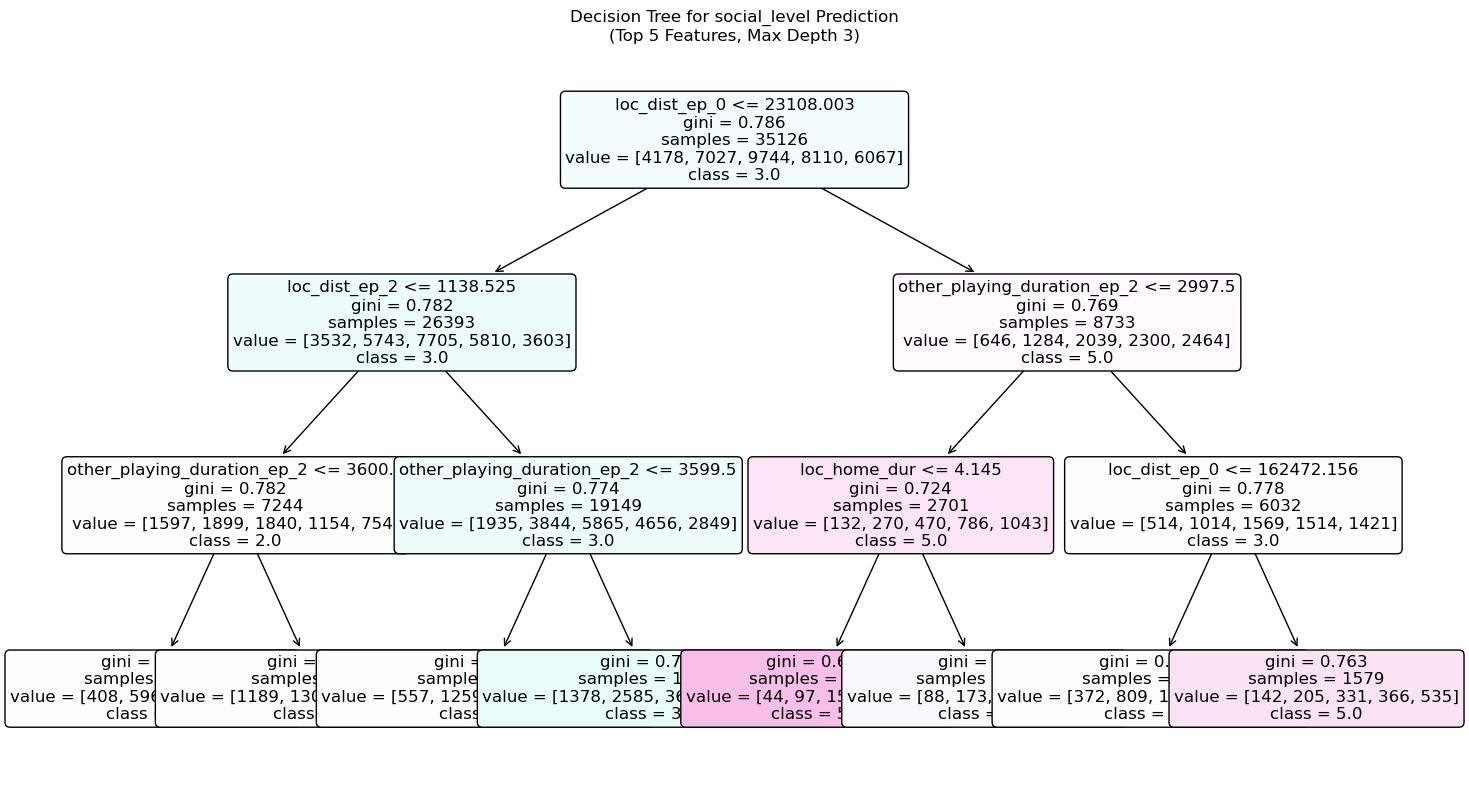


Decision Rules:

Simplified tree for phq4_score

Top Feature Importance:
              feature  importance
651            stress    0.241985
1                 day    0.019713
621   unlock_num_ep_0    0.015725
192  act_walking_ep_2    0.009133
116    act_still_ep_2    0.007326


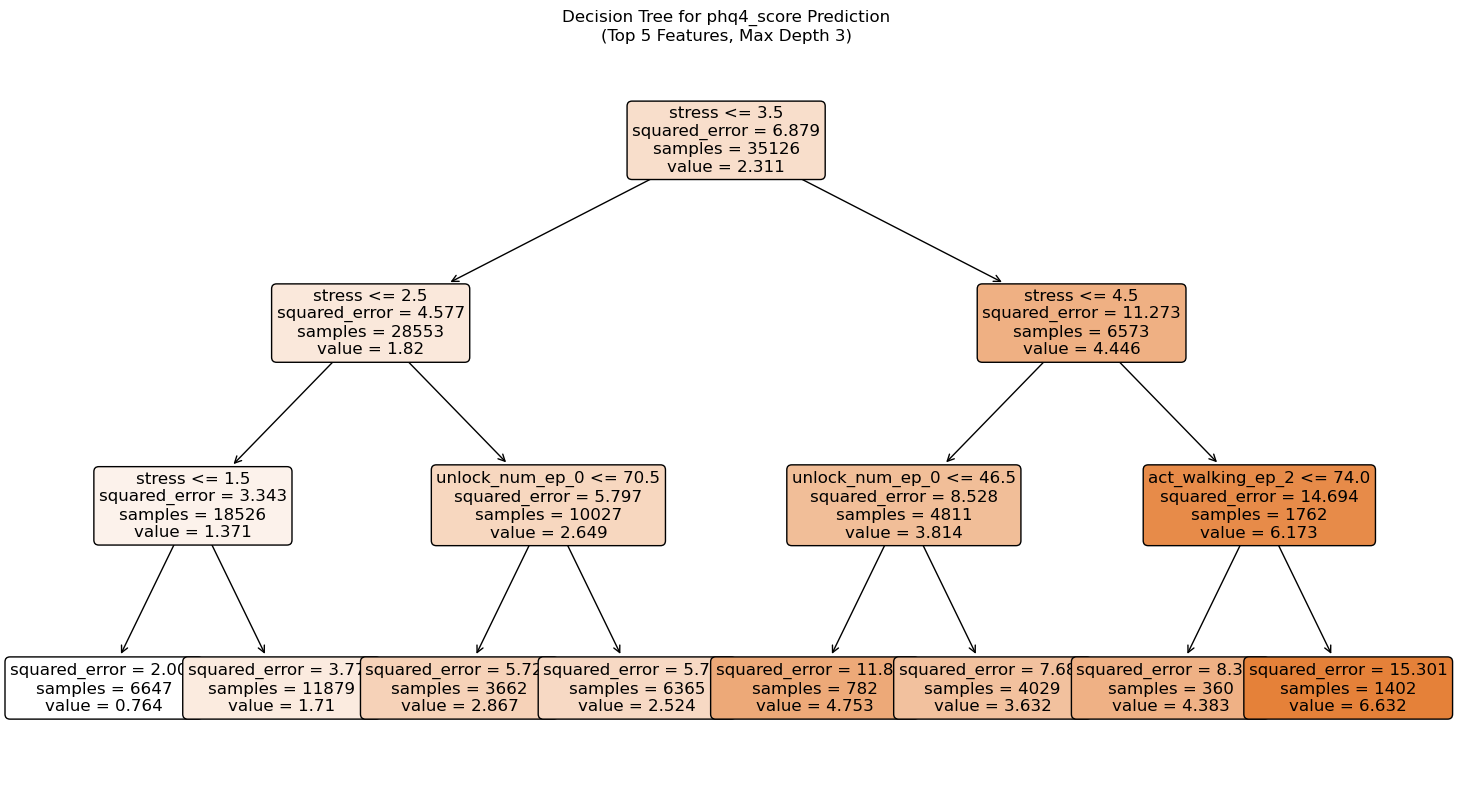


Decision Rules:

Simplified tree for pam

Top Feature Importance:
                   feature  importance
651                 stress    0.015799
0                   is_ios    0.013832
1                      day    0.010856
608  unlock_duration_hr_19    0.007866
606  unlock_duration_hr_17    0.007847


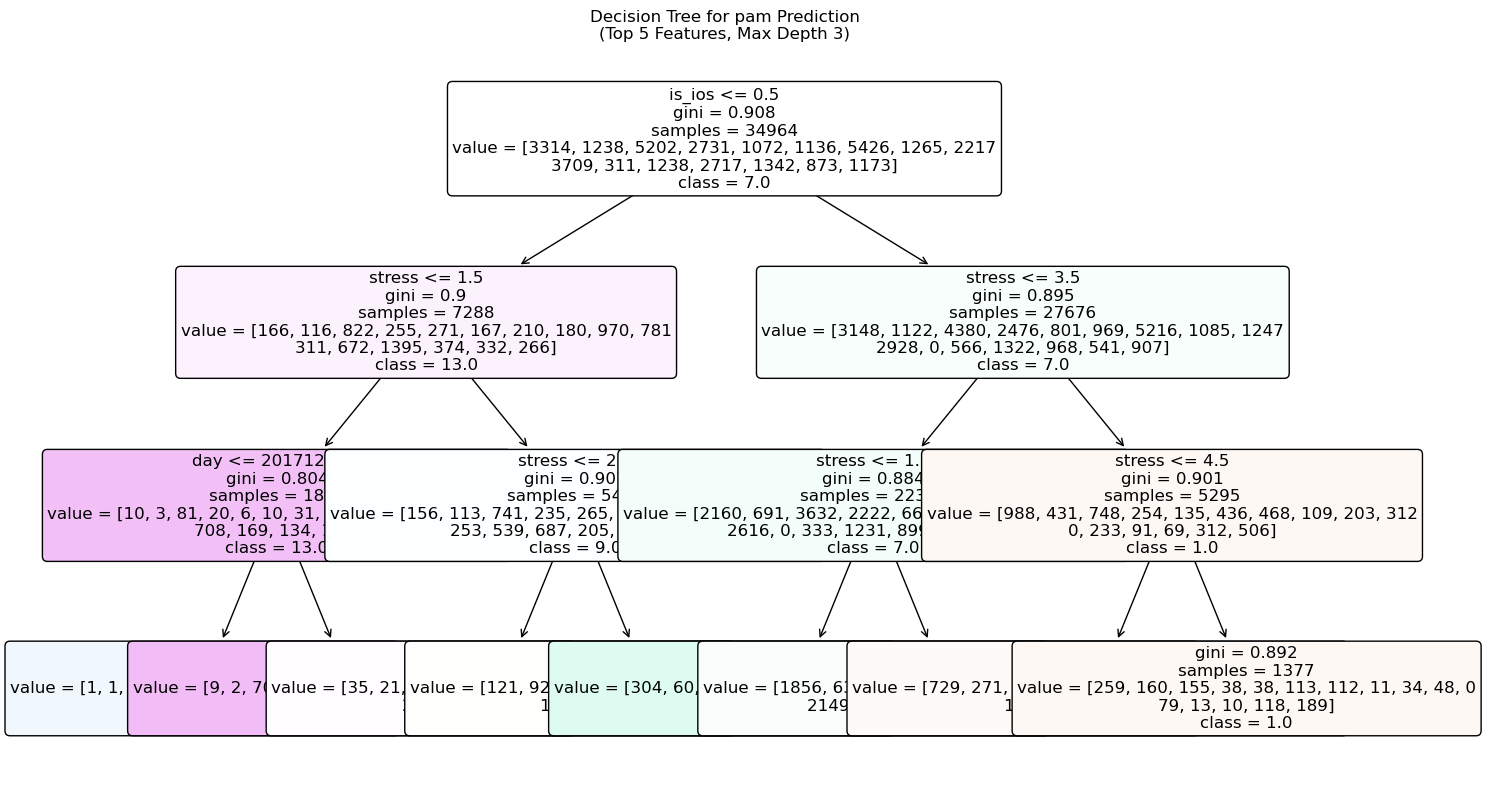


Decision Rules:


In [18]:
def visualize_simplified_tree(merged_data, target_col, n_features=5, max_depth=3, platform='all', is_classification=True):
    """
    Create a simplified tree visualization using only top N features from a single Decision Tree
    """
    # Filter data based on platform
    if platform == 'android':
        data = merged_data[merged_data['is_ios'] == 0].copy()
    elif platform == 'ios':
        data = merged_data[merged_data['is_ios'] == 1].copy()
    else:
        data = merged_data.copy()
    
    # Remove EMA-related features
    numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
    ema_cols = [col for col in numeric_cols if any(x in col.lower() for x in ['ema', 'phq', 'sse', 'pam'])]
    feature_cols = [col for col in numeric_cols if col not in ema_cols and col != target_col]
    
    X = data[feature_cols]
    y = data[target_col].dropna()
    X = X.loc[y.index]
    
    # Handle missing values
    imputer = SimpleImputer(strategy='median')
    X = pd.DataFrame(imputer.fit_transform(X), columns=feature_cols)
    
    # Get feature importance using a single decision tree
    if is_classification:
        initial_model = DecisionTreeClassifier(random_state=42)
    else:
        initial_model = DecisionTreeRegressor(random_state=42)
    
    initial_model.fit(X, y)
    
    # Select top N features
    importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': initial_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Print feature importance
    print("\nTop Feature Importance:")
    print(importance.head(n_features))
    
    top_features = importance.head(n_features)['feature'].tolist()
    X = X[top_features]
    
    # Create and train the final decision tree with limited depth
    if is_classification:
        tree_model = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    else:
        tree_model = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    
    tree_model.fit(X, y)
    
    # Visualize the tree
    plt.figure(figsize=(15,8))
    plot_tree(tree_model, 
             feature_names=top_features,
             class_names=[str(c) for c in tree_model.classes_] if is_classification else None,
             filled=True,
             rounded=True,
             fontsize=12)
    plt.title(f'Decision Tree for {target_col} Prediction\n(Top {n_features} Features, Max Depth {max_depth})')
    plt.tight_layout()
    plt.show()
    
    # Print the decision rules
    print("\nDecision Rules:")
    for i, feature in enumerate(top_features):
        if feature in tree_model.feature_importances_:
            importance_score = tree_model.feature_importances_[i]
            print(f"{feature}: {importance_score:.4f}")
    
    return tree_model, importance.head(n_features)

# Example usage
for target in targets:
    print(f"\n{'='*50}")
    print(f"Simplified tree for {target['col']}")
    print(f"{'='*50}")
    
    model, importance = visualize_simplified_tree(
        merged_data,
        target['col'],
        n_features=5,  # Show top 5 features
        max_depth=3,   # Limit depth for readability
        platform='all',
        is_classification=target['is_classification']
    )

In [12]:
def run_predictions(merged_data, target_quarter, target_year, platform='all', feature_set=None, feature_list=None):
    """
    Run predictions for different target variables
    platform: 'all', 'android', or 'ios'
    feature_set: list of feature categories to include
    """
    prediction_tasks = [
        {
            'col': 'stress',
            'is_classification': True,
            'description': 'Current stress level (1-5)'
        },
        {
            'col': 'social_level',
            'is_classification': True,
            'description': 'Social interaction level (1-5)'
        },
        {
            'col': 'phq4_score',
            'is_classification': True,
            'description': 'PHQ4 depression/anxiety score (0-12)'
        },
        {
            'col': 'pam',
            'is_classification': True,
            'description': 'Photographic Affect Meter score (1-16)'
        }
    ]
    
    results = {}
    for task in prediction_tasks:
        model = PredictiveModel(
            target_col=task['col'],
            is_classification=task['is_classification'],
            platform=platform,
            feature_set=feature_set,
            feature_dict=feature_dict,
            feature_list=feature_list
        )
        results[task['col']] = model.train_evaluate(
            merged_data, 
            target_quarter, 
            target_year
        )
        # Add tree visualization
        print(f"\nDecision Tree Visualization for {task['col']}")
        print("-" * 50)
        
        # Create simplified tree visualization
        tree_model = visualize_simplified_tree(
            merged_data=merged_data,
            target_col=task['col'],
            n_features=5,  # Show top 5 features
            max_depth=3,   # Limit depth for readability
            platform=platform,
            is_classification=task['is_classification']
        )
        
        # Store tree model in results
        results[task['col']]['tree_model'] = tree_model
        
        # Print feature importance for this task
        feature_importance = pd.DataFrame({
            'feature': model.get_platform_features(merged_data),
            'importance': tree_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print("\nTop 10 Most Important Features:")
        print(feature_importance.head(3))

    
    return results

In [13]:
def print_results(results, platform_name):
    """
    Helper function to print results in a formatted way
    """
    print("\n" + "="*50)
    print(f"Results for {platform_name}")
    print("="*50)
    
    for target, metrics in results.items():
        print(f"\n--- {target.upper()} ---")
        
        # Check if there was an error
        if 'error' in metrics:
            print(f"Error: {metrics['error']}")
            continue
            
        # Print sample sizes
        print(f"\nSample Sizes:")
        print(f"  Training samples: {metrics['n_train']}")
        print(f"  Testing samples:  {metrics['n_test']}")
        
        # Print performance metrics
        print("\nPerformance Metrics:")
        if 'accuracy' in metrics:  # Classification metrics
            print(f"  Accuracy:  {metrics['accuracy']:.3f}")
            print(f"  F1 Score:  {metrics['f1_score']:.3f}")
        else:  # Regression metrics
            print(f"  MSE:  {metrics['mse']:.3f}")
            print(f"  RMSE: {metrics['rmse']:.3f}")


Training data shape: (5986, 7)
Testing data shape: (2905, 7)
Number of features used: 7

Decision Tree Visualization for stress
--------------------------------------------------


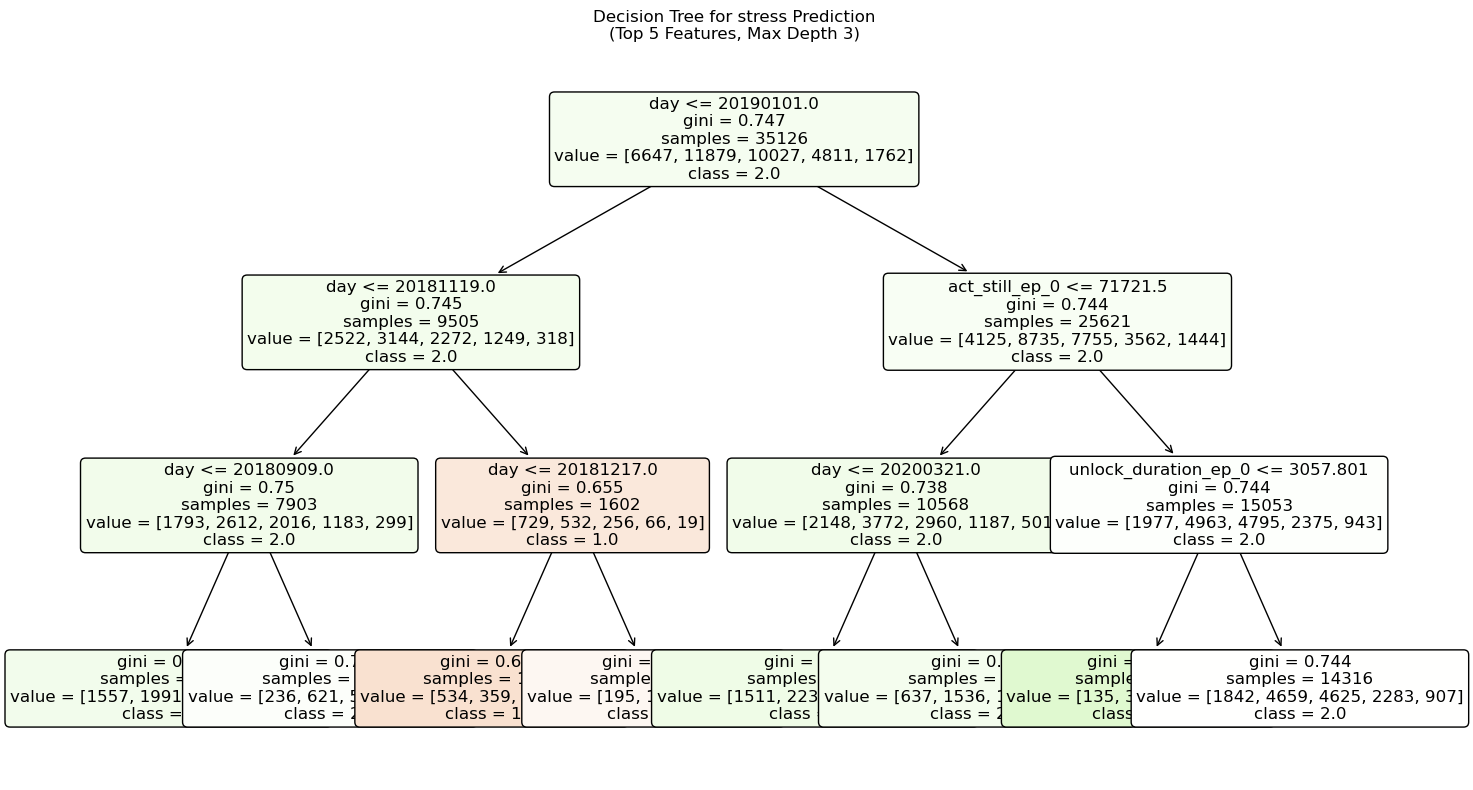

ValueError: All arrays must be of the same length

In [16]:
target_quarter = 2  # Spring
target_year = 2019

merged_data = prepare_merged_dataset(sensing_data, demographics_data, ema_data)

# # Run with phone and sleep features for iOS
results_subset = run_predictions(merged_data, target_quarter, target_year,
                               platform='all', 
                               feature_list=['act_still_ep_0', 'act_still_ep_2', 'act_still_ep_3', 'act_still_ep_1',
                                             'sleep_duration', 'sleep_start', 'sleep_end'])
print_results(results_subset, "All Platforms - Activity")


Analyzing features for stress


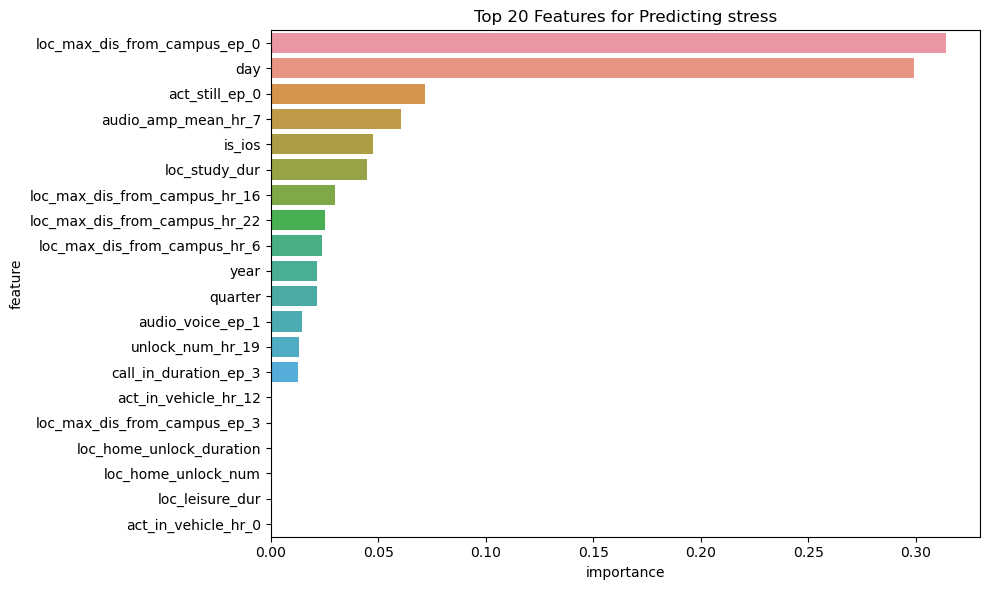


Top 20 Features:
loc_max_dis_from_campus_ep_0: 0.3141
day: 0.2993
act_still_ep_0: 0.0719
audio_amp_mean_hr_7: 0.0607
is_ios: 0.0474
loc_study_dur: 0.0449
loc_max_dis_from_campus_hr_16: 0.0301
loc_max_dis_from_campus_hr_22: 0.0250
loc_max_dis_from_campus_hr_6: 0.0240
year: 0.0214
quarter: 0.0213
audio_voice_ep_1: 0.0145
unlock_num_hr_19: 0.0130
call_in_duration_ep_3: 0.0125
act_in_vehicle_hr_12: 0.0000
loc_max_dis_from_campus_ep_3: 0.0000
loc_home_unlock_duration: 0.0000
loc_home_unlock_num: 0.0000
loc_leisure_dur: 0.0000
act_in_vehicle_hr_0: 0.0000


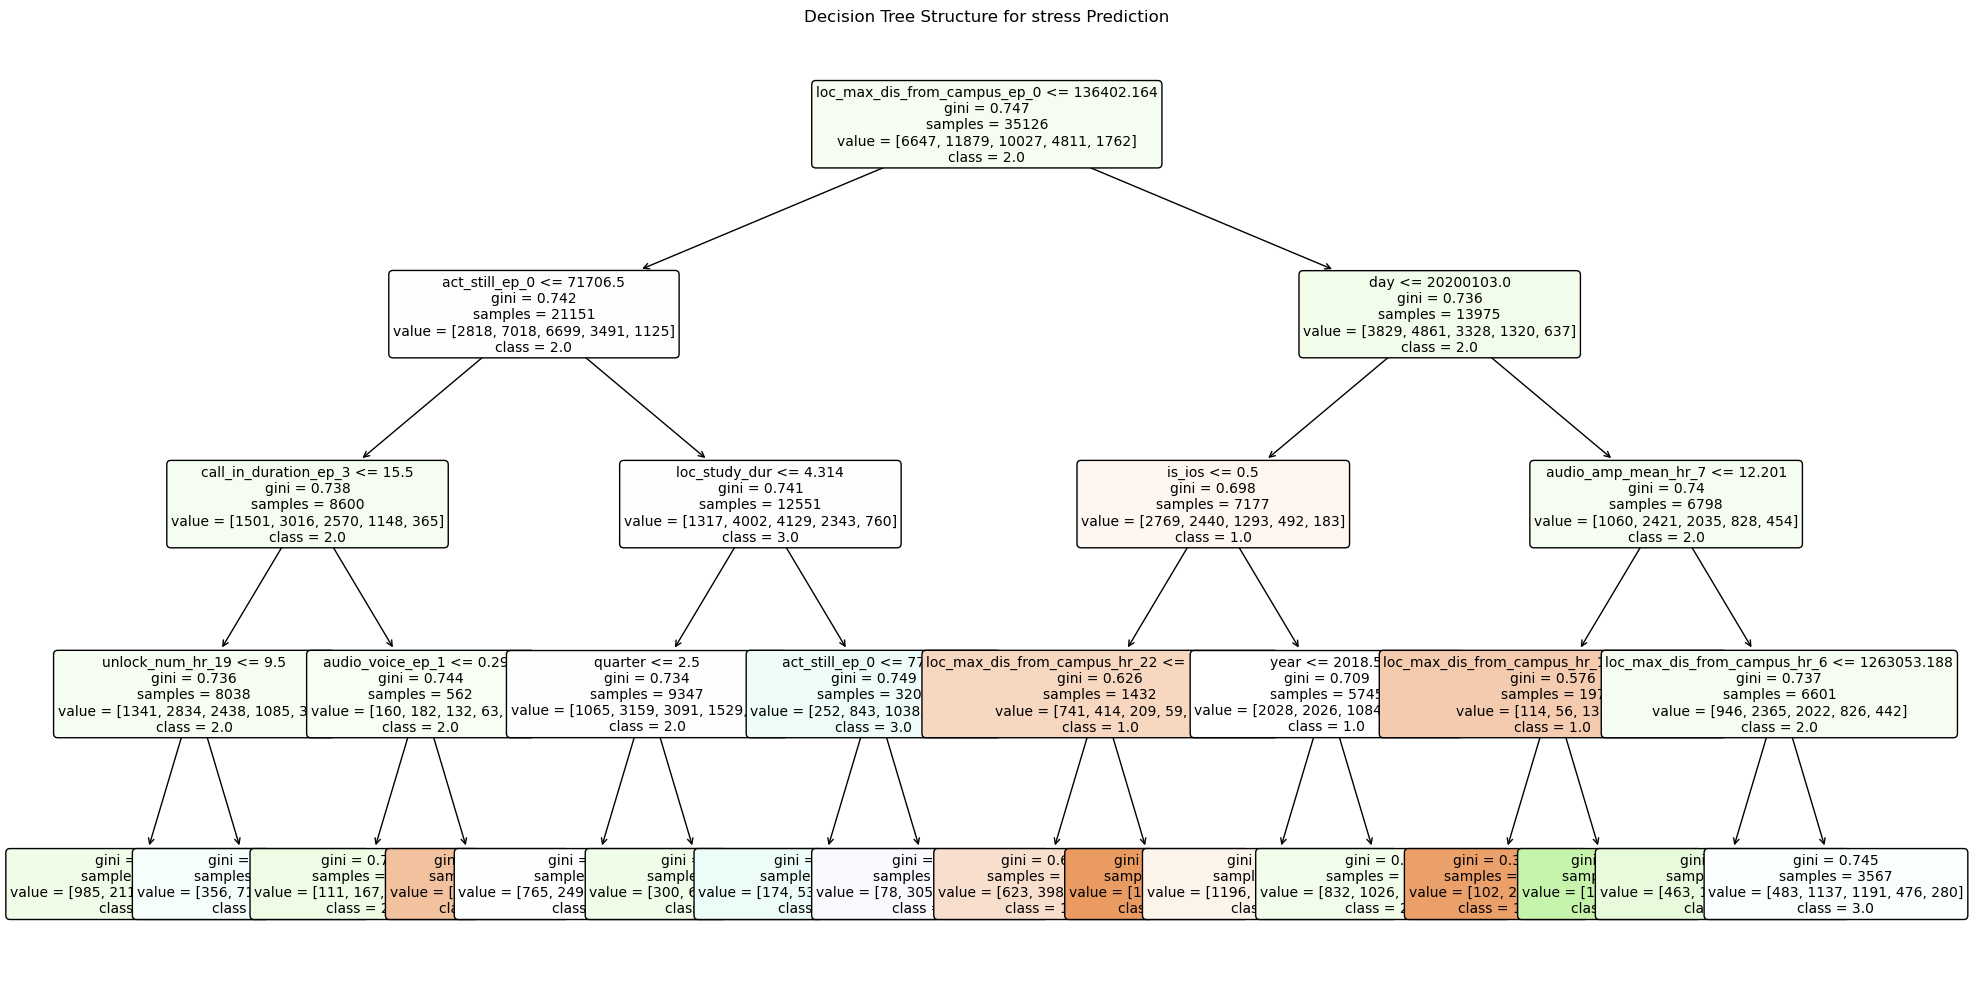


Analyzing features for social_level


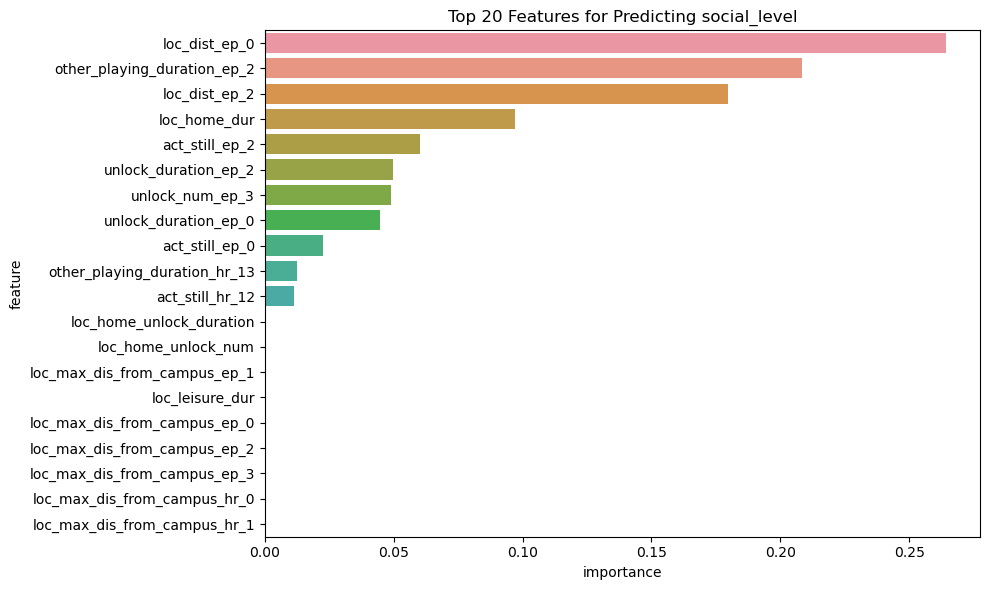


Top 20 Features:
loc_dist_ep_0: 0.2643
other_playing_duration_ep_2: 0.2086
loc_dist_ep_2: 0.1799
loc_home_dur: 0.0973
act_still_ep_2: 0.0604
unlock_duration_ep_2: 0.0496
unlock_num_ep_3: 0.0490
unlock_duration_ep_0: 0.0446
act_still_ep_0: 0.0227
other_playing_duration_hr_13: 0.0124
act_still_hr_12: 0.0114
loc_home_unlock_duration: 0.0000
loc_home_unlock_num: 0.0000
loc_max_dis_from_campus_ep_1: 0.0000
loc_leisure_dur: 0.0000
loc_max_dis_from_campus_ep_0: 0.0000
loc_max_dis_from_campus_ep_2: 0.0000
loc_max_dis_from_campus_ep_3: 0.0000
loc_max_dis_from_campus_hr_0: 0.0000
loc_max_dis_from_campus_hr_1: 0.0000


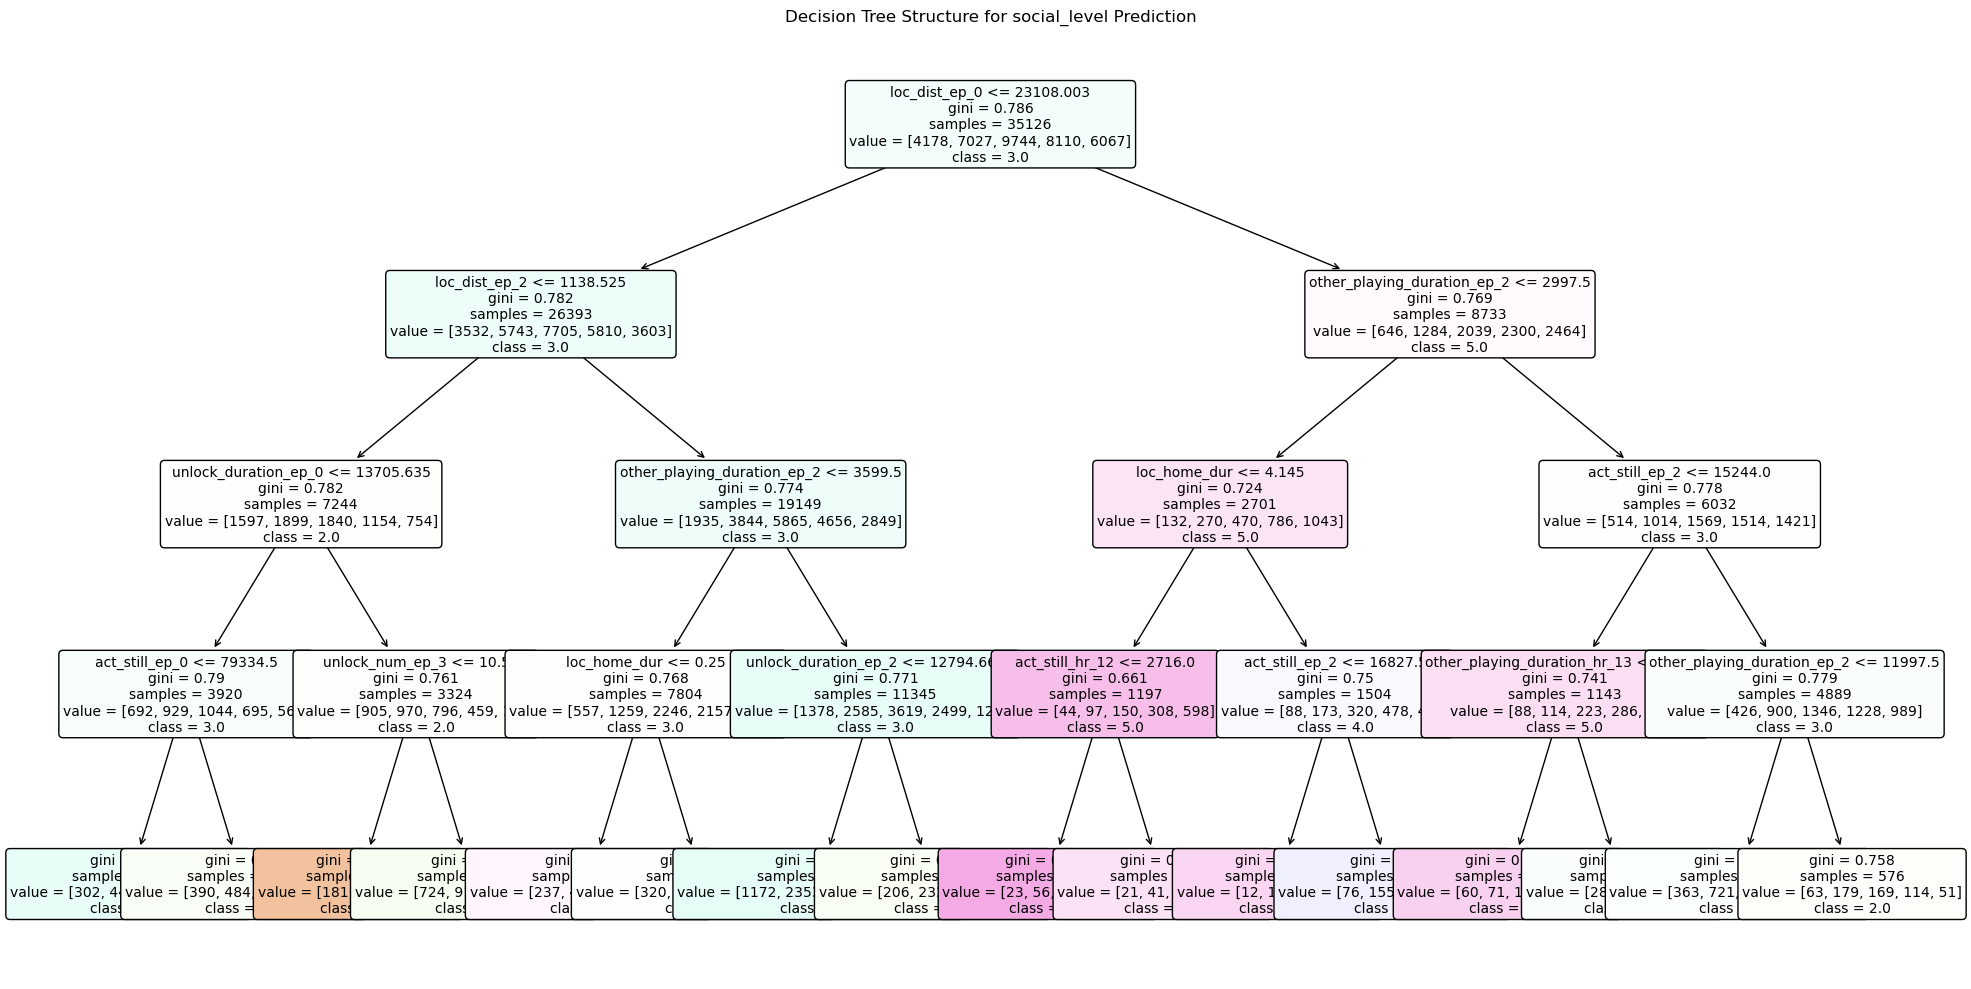


Analyzing features for phq4_score


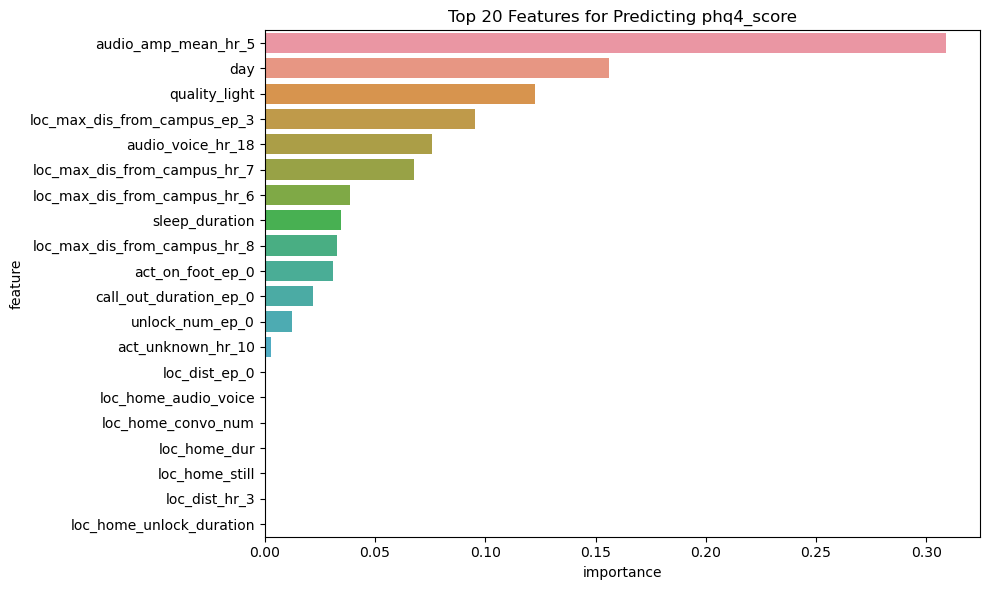


Top 20 Features:
audio_amp_mean_hr_5: 0.3089
day: 0.1560
quality_light: 0.1224
loc_max_dis_from_campus_ep_3: 0.0954
audio_voice_hr_18: 0.0757
loc_max_dis_from_campus_hr_7: 0.0676
loc_max_dis_from_campus_hr_6: 0.0385
sleep_duration: 0.0347
loc_max_dis_from_campus_hr_8: 0.0326
act_on_foot_ep_0: 0.0310
call_out_duration_ep_0: 0.0218
unlock_num_ep_0: 0.0124
act_unknown_hr_10: 0.0026
loc_dist_ep_0: 0.0004
loc_home_audio_voice: 0.0000
loc_home_convo_num: 0.0000
loc_home_dur: 0.0000
loc_home_still: 0.0000
loc_dist_hr_3: 0.0000
loc_home_unlock_duration: 0.0000


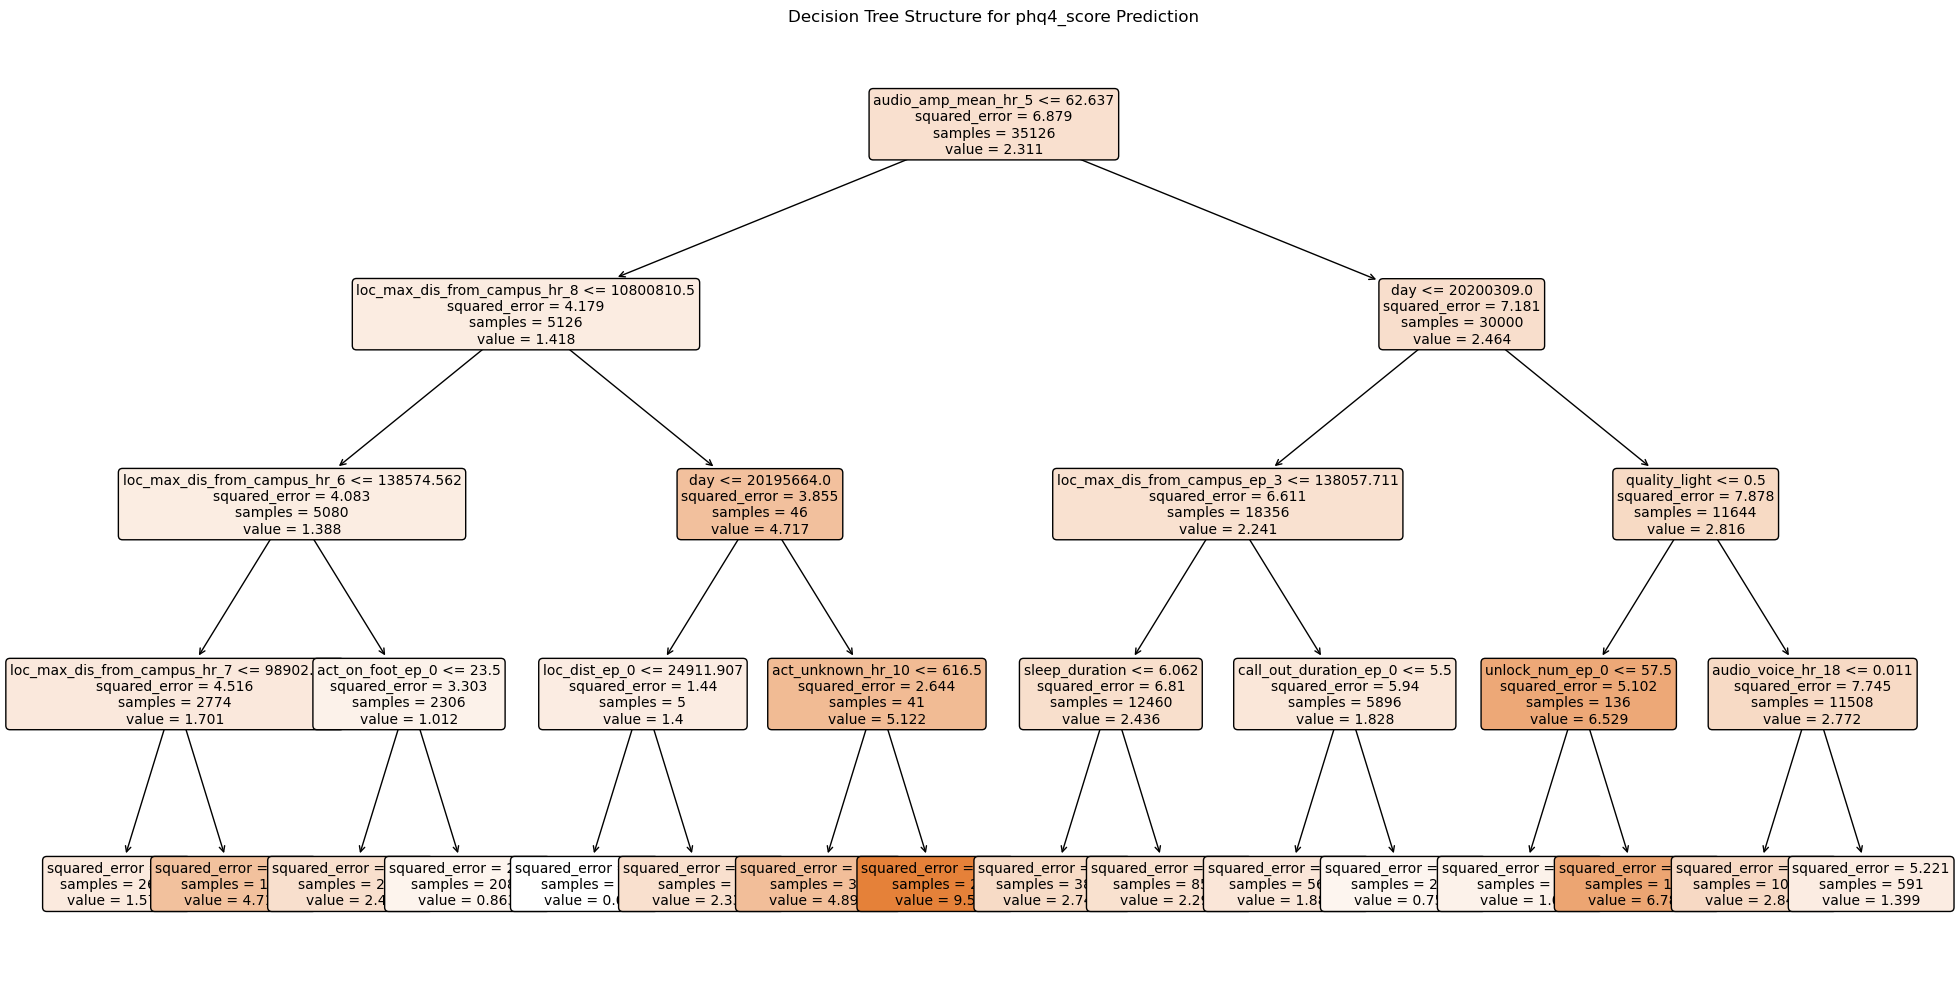


Analyzing features for pam


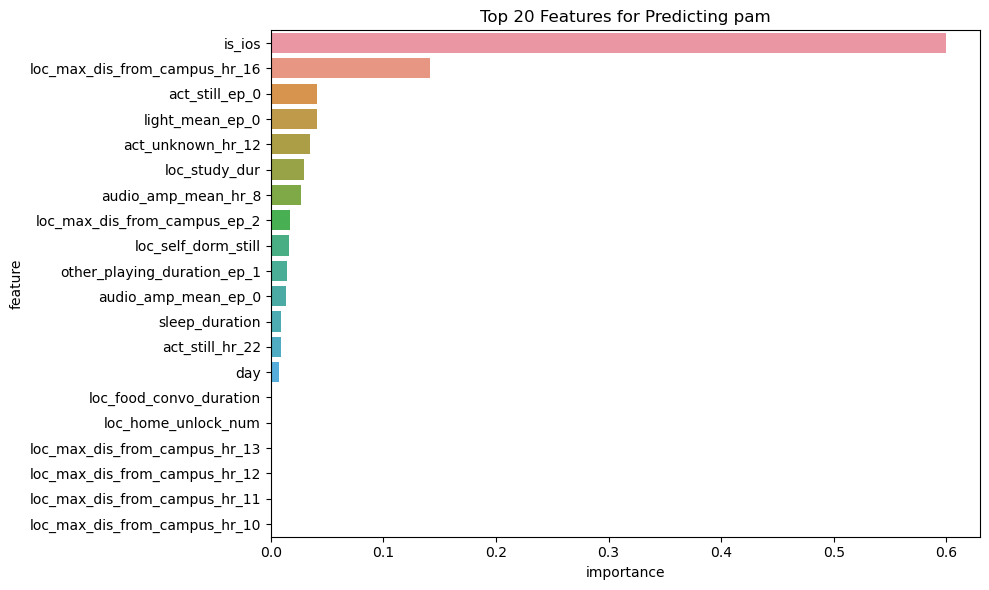


Top 20 Features:
is_ios: 0.5998
loc_max_dis_from_campus_hr_16: 0.1415
act_still_ep_0: 0.0414
light_mean_ep_0: 0.0407
act_unknown_hr_12: 0.0348
loc_study_dur: 0.0292
audio_amp_mean_hr_8: 0.0266
loc_max_dis_from_campus_ep_2: 0.0172
loc_self_dorm_still: 0.0160
other_playing_duration_ep_1: 0.0141
audio_amp_mean_ep_0: 0.0136
sleep_duration: 0.0094
act_still_hr_22: 0.0089
day: 0.0069
loc_food_convo_duration: 0.0000
loc_home_unlock_num: 0.0000
loc_max_dis_from_campus_hr_13: 0.0000
loc_max_dis_from_campus_hr_12: 0.0000
loc_max_dis_from_campus_hr_11: 0.0000
loc_max_dis_from_campus_hr_10: 0.0000


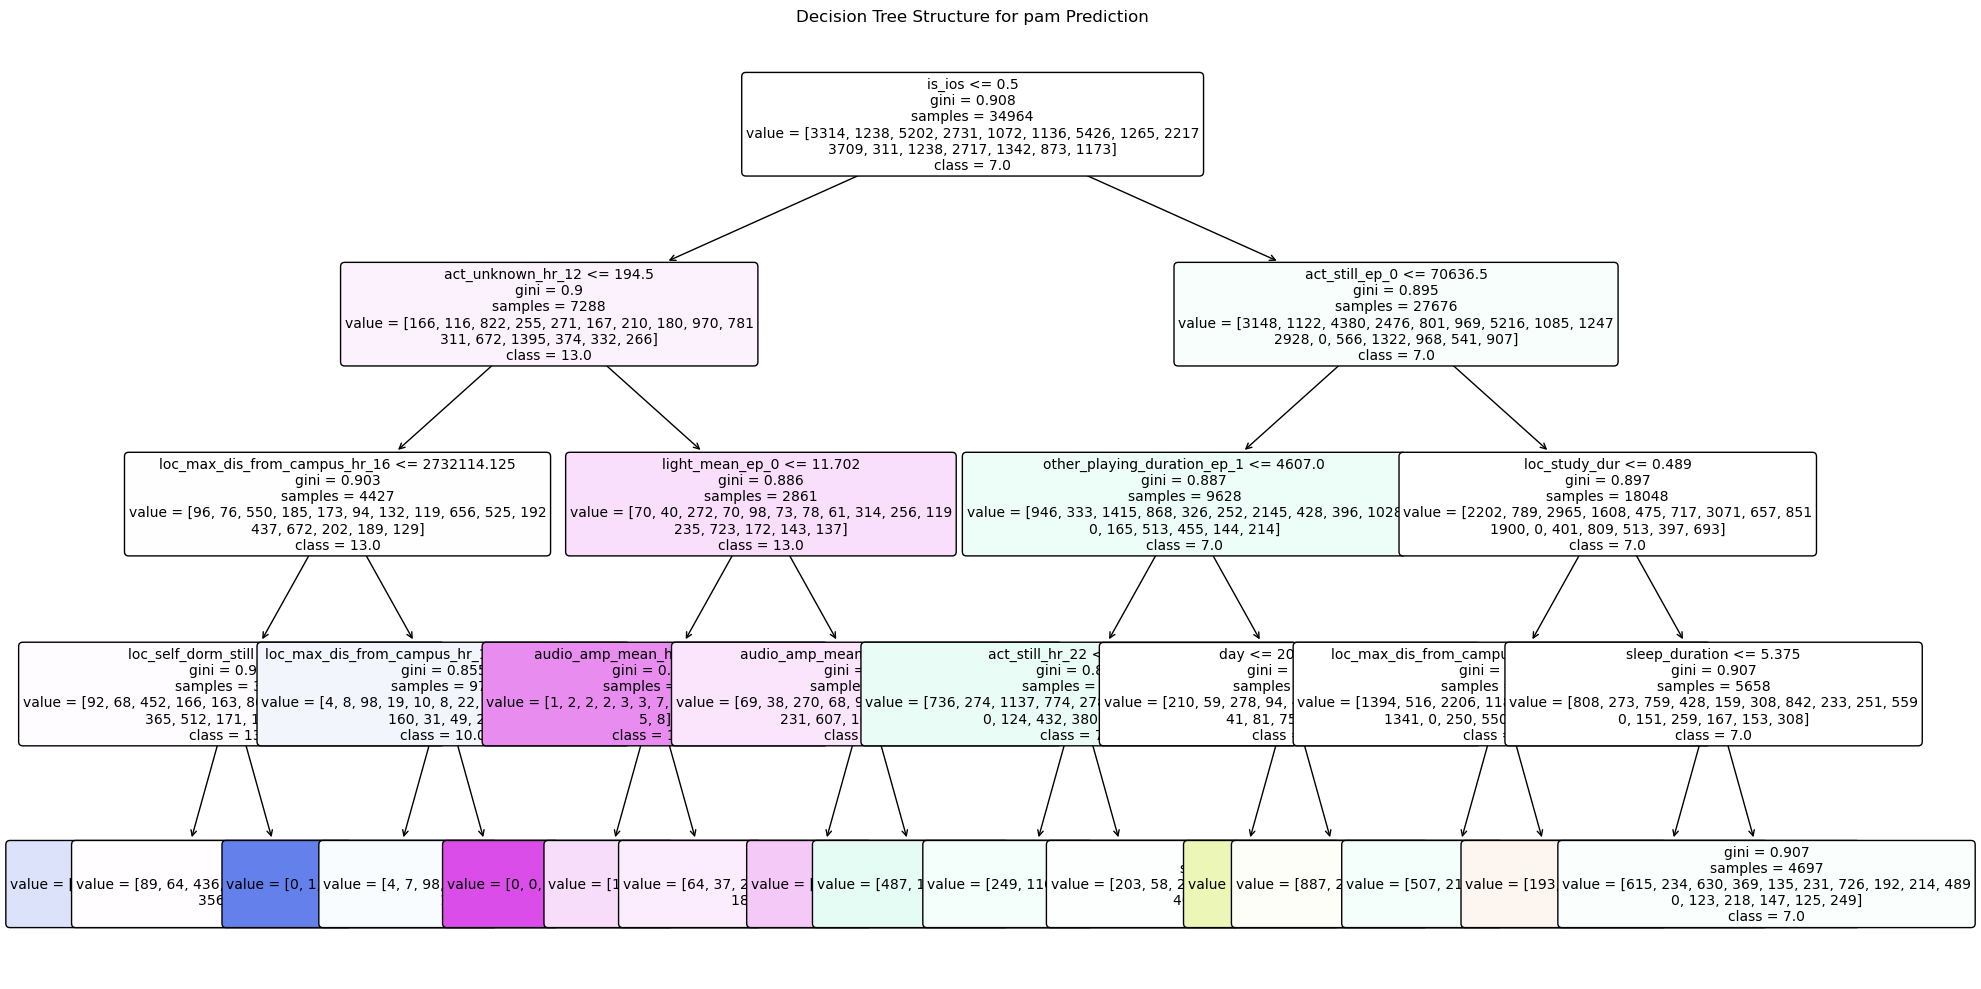

In [17]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_feature_importance(merged_data, target_col, platform='all', is_classification=True, max_depth=5):
    """
    Analyze feature importance using a single Decision Tree
    """
    # Filter platform if needed
    if platform == 'android':
        data = merged_data[merged_data['is_ios'] == 0].copy()
    elif platform == 'ios':
        data = merged_data[merged_data['is_ios'] == 1].copy()
    else:
        data = merged_data.copy()
    
    # Remove rows where target is NaN
    data = data.dropna(subset=[target_col])
    
    # Get numeric columns (excluding EMA-related features)
    numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
    ema_cols = [col for col in numeric_cols if any(x in col.lower() 
                for x in ['ema', 'phq', 'sse', 'pam', 'stress', 'social'])]
    feature_cols = [col for col in numeric_cols if col not in ema_cols and col != target_col]
    
    X = data[feature_cols]
    y = data[target_col]
    
    # Handle missing values
    imputer = SimpleImputer(strategy='median')
    X = pd.DataFrame(imputer.fit_transform(X), columns=feature_cols)
    
    # Train a Decision Tree
    if is_classification:
        model = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    else:
        model = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    
    # Fit model
    model.fit(X, y)
    
    # Get feature importance
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df.head(20), x='importance', y='feature')
    plt.title(f'Top 20 Features for Predicting {target_col}')
    plt.tight_layout()
    plt.show()
    
    # Print top features
    print("\nTop 20 Features:")
    for idx, row in importance_df.head(20).iterrows():
        print(f"{row['feature']}: {row['importance']:.4f}")
    
    # Visualize the tree structure
    plt.figure(figsize=(20, 10))
    plot_tree(model, 
             feature_names=feature_cols,
             class_names=[str(c) for c in model.classes_] if is_classification else None,
             filled=True,
             rounded=True,
             fontsize=10)
    plt.title(f'Decision Tree Structure for {target_col} Prediction')
    plt.tight_layout()
    plt.show()
    
    return model, importance_df

# Example usage for each target
targets = [
    {'col': 'stress', 'is_classification': True},
    {'col': 'social_level', 'is_classification': True},
    {'col': 'phq4_score', 'is_classification': False},
    {'col': 'pam', 'is_classification': True}
]

# Analyze each target
for target in targets:
    print(f"\n{'='*50}")
    print(f"Analyzing features for {target['col']}")
    print(f"{'='*50}")
    
    model, importance_df = analyze_feature_importance(
        merged_data,
        target['col'],
        platform='all',
        is_classification=target['is_classification'],
        max_depth=4  # Adjust this for tree complexity
    )